Importo los pequetes y módulos que voy a necesitas

In [4]:
import pandas as pd
import squarify
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from bootcampviztools import plot_categorical_relationship_fin, pinta_distribucion_categoricas, plot_grouped_histograms,\
    plot_grouped_boxplots, plot_combined_graphs, plot_categorical_numerical_relationship, bubble_plot,\
        grafico_dispersion_con_correlacion
from scipy.stats import chi2_contingency, mannwhitneyu

Cargo en un DataFrame el dataset del titanic

In [5]:
df_titanic = pd.read_csv("./data/titanic.csv")

### **LIMPIO LOS DATOS**

Me voy a deshacfer de las columnas "deck", "survived", "pclass" y "embarked" porque no las voy a utilizar, la primera por su cantidad de nulos y el resto porque son variantes de otras que ya existen y cuyos valores resultan más expresivos a la hora de hacer un análisis.

In [6]:
df_titanic.drop(columns=["deck","survived","pclass","embarked"], inplace= True)

Imputo la moda a los valores nulos de "embark_town"

In [7]:
df_titanic.loc[df_titanic.embark_town.isna(), "embark_town"] = df_titanic.embark_town.mode()[0]

Sumo las columnas "parch" y "sibsp" para tener el número de parientes de cada pasajero y guarda el resultado en otra columna "family_members" paara después deshacerme de "parch" y "sibsp"

In [8]:
df_titanic["family_members"] = df_titanic.parch + df_titanic.sibsp

In [9]:
df_titanic = df_titanic.drop(["parch","sibsp"], axis = 1)

Imputo la media a los valores faltantes de "age", considerando además la columna "who"

In [10]:
es_woman = df_titanic.who == "woman"
es_child = df_titanic.who == "child"
es_man = df_titanic.who == "man"

media_woman = df_titanic.loc[es_woman,"age"].mean()
media_child = df_titanic.loc[es_child,"age"].mean()
media_man = df_titanic.loc[es_man,"age"].mean()

es_age_nulo = df_titanic.age.isna()

df_titanic.loc[es_woman & es_age_nulo, "age"] = media_woman
df_titanic.loc[es_child & es_age_nulo, "age"] = media_child
df_titanic.loc[es_man & es_age_nulo, "age"] = media_man

### **DEFINO Y TIPIFICO LAS VARIABLES**

Creo una función para tipificar las variables

In [11]:
def cardinalidad(df_in, umbral_categoria, umbral_continua):
    # Creo un DataFrame para almacenar los resultados
    df_tipificacion = pd.DataFrame({
        'Card': df_in.nunique(),  # Cardinalidad
        '%_Card': df_in.nunique() / len(df_in) * 100,  # Porcentaje de cardinalidad
        'Tipo': df_in.dtypes  # Tipo de dato
    })
    

    # Inicializo la columna de clasificación como vacía
    df_tipificacion["Clasificación_como"] = ""
    
    # Aplico las reglas de clasificación
    for col in df_tipificacion.index:
        card = df_tipificacion.loc[col, 'Card']
        porcentaje = df_tipificacion.loc[col, '%_Card']
                
        if card == 2:
            df_tipificacion.at[col, "Clasificación_como"] = "Binaria" 
        elif card < umbral_categoria:
            df_tipificacion.at[col, "Clasificación_como"] = "Categórica"
        else:
            if porcentaje >= umbral_continua:
                df_tipificacion.at[col, "Clasificación_como"] = "Numérica Continua"
            else:
                df_tipificacion.at[col, "Clasificación_como"] = "Numérica Discreta"
    
    return df_tipificacion

In [12]:
cardinalidad = cardinalidad(df_titanic, 10, 20)
cardinalidad

,Card,%_Card,Tipo,Clasificación_como
sex,2,0.224467,object,Binaria
age,89,9.988777,float64,Numérica Discreta
fare,248,27.833895,float64,Numérica Continua
class,3,0.336700,object,Categórica
who,3,0.336700,object,Categórica
adult_male,2,0.224467,bool,Binaria
embark_town,3,0.336700,object,Categórica
alive,2,0.224467,object,Binaria
alone,2,0.224467,bool,Binaria
family_members,9,1.010101,int64,Categórica


Creo la tabla de las variables sin dar valor a la importancia inicial marcándola por cada objetivo.

|Columna/Variable|Descripción|Tipo_de_Variable|Importancia inicial|Nota|
|-|-|-|-|-|
|sex|sexo de la persona que embarcó|Binaria||Influye en el objetivo pero nos interesa más la varivale `who`|
|age|Edad de la persona indicada|Numérica discreta||Demográfica|
|fare|Tarifa de la persona indicada|Numérica continua||Relacionado con la clase que pertenecieron|
|class|Clase donde estuvo la persona en el barco|Categórica||Se puede ver si está relacionado si fueron más "ricos" los que sobrevivieron o los "pobres"|
|who|Indica si es hombre, mujer o niño/a|Categórica||Demográfica|
|adult_male|Indica si la persona es adulta y del sexo masculino (True o False)|Binaria|||
|embark_town|Ciudades donde se embarcó|Categórica||Demográfica|
|alive|Muestra si la persona ha sobrevivido o no|Binaria||El True representa a sí y el False a no|
|alone|Si viajó sola o no|Binaria|||
|family_members|Número de familiares con la que viajaba la persona indicada|Categórica|||

### **ANÁLISIS**

##### **Marco el objetivo principal**

- *Tasa de mortalidad y supervivencia en el Titanic*

Por lo que `alive` será el target o la variable directora

> 1. Analizamos esta variable categórida de manera univariante. Es decir, pintaremos el histograma con sus valores relativos

In [13]:
# Calculo cuántas personas embarcaron en el Titanic del dataset
len(df_titanic)

891

In [14]:
# Cuantas sobrevivieron y fallecieron
# Absoluta
absoluta = df_titanic.alive.value_counts()
absoluta

alive
no     549
yes    342
Name: count, dtype: int64

In [15]:
# Relativa
relativa = round(df_titanic["alive"].value_counts() / len(df_titanic) * 100, 2)
relativa

alive
no     61.62
yes    38.38
Name: count, dtype: float64

*En términos relativos fallecieron más las personas que viajaron en el Titanic con un 62% frente a un 38% las personas que fallecieron. Por lo que la tasa de mortalidad fue un índice elevado.*

Creo el diagrama de barras en `plp` para visualizarlo en la presentación 

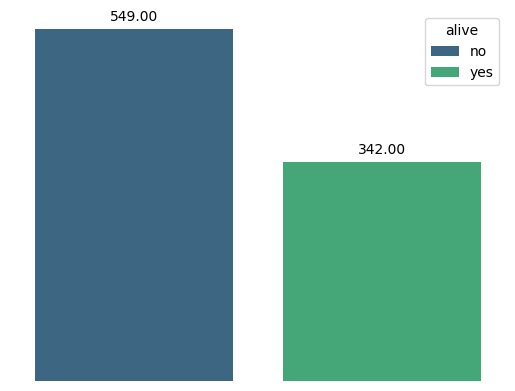

In [16]:
# La rescato del fichero "bootcampviztools.py"

serie = df_titanic["alive"].value_counts()
ax = sns.barplot(x=serie.index, y=serie, palette='viridis', hue = serie.index, legend = True)
ax.set_ylabel('Frecuencia')

for container in ax.containers:
    for p in container.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points')

plt.axis("off");

> 2. Análisis bivariante de `who` y `alive`

In [17]:
# Frecuencias absolutas y relativas de 'who'

absoluta_who = df_titanic.who.value_counts()
relativa_who = round(df_titanic.who.value_counts() / len(df_titanic) * 100, 2)

print(absoluta_who)
print("\n", relativa_who)

who
man      537
woman    271
child     83
Name: count, dtype: int64

 who
man      60.27
woman    30.42
child     9.32
Name: count, dtype: float64


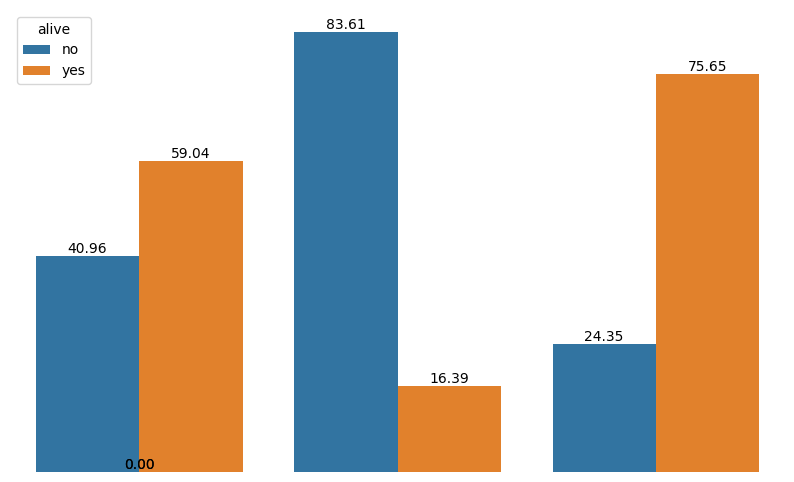

In [18]:
# Creo el diagrama de barras para compararlo de manera bivariante
# La rescato del fichero "bootcampviztools.py" para ayudarme en la presentación

# Prepara los datos
count_data = df_titanic.groupby(["who", "alive"]).size().reset_index(name='count')
total_counts = df_titanic["who"].value_counts()

count_data['count'] = count_data.apply(lambda x: x['count'] / total_counts[x["who"]] * 100, axis=1)


plt.figure(figsize=(10, 6))
ax = sns.barplot(x="who", y='count', hue="alive", data=count_data)

# Mostrar valores en el gráfico
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.axis("off");

* *En términos absolutos murieron muchos más hombres que cualquiera de los otros dos grupos*
* *En términos relativos,también la mortalidad fue superior (visualmente muy superior al del resto de grupos, 84% vs 41% en niños y 24% en mujeres). Y además comparado con la media total se ve claramente que está por encima.*

In [19]:
tabla_contingencia = pd.crosstab(df_titanic["alive"],df_titanic["who"])

chi2, p, dof, expected = chi2_contingency(tabla_contingencia)

print("Valor Chi-Cuadrado:", chi2)
print("P-Value:", p)
print("Grados de Libertad:", dof)
print("Tabla de Frecuencias Esperadas:\n", expected)

Valor Chi-Cuadrado: 283.923050324233
P-Value: 2.2227620817798914e-62
Grados de Libertad: 2
Tabla de Frecuencias Esperadas:
 [[ 51.14141414 330.87878788 166.97979798]
 [ 31.85858586 206.12121212 104.02020202]]


*Claramente podemos rechazar la hipótesis nula de no dependencia y considerar que sí que hay una relación entre el grupo de edad-sexo y la supervivencia estadísticamente significativa. Ser hombre en el titanic fue duro*  
*Pero otro dato interesante es el hecho de que el grupo de los niños sufrió una mortalidad más del doble que el de las mujeres... Mujeres y niños primero,... Por ejemplo un multivariante con clase* 

> 3. Para seguir con nuestro EDA, realizaré un análisis bivariante entre `class` y `who`

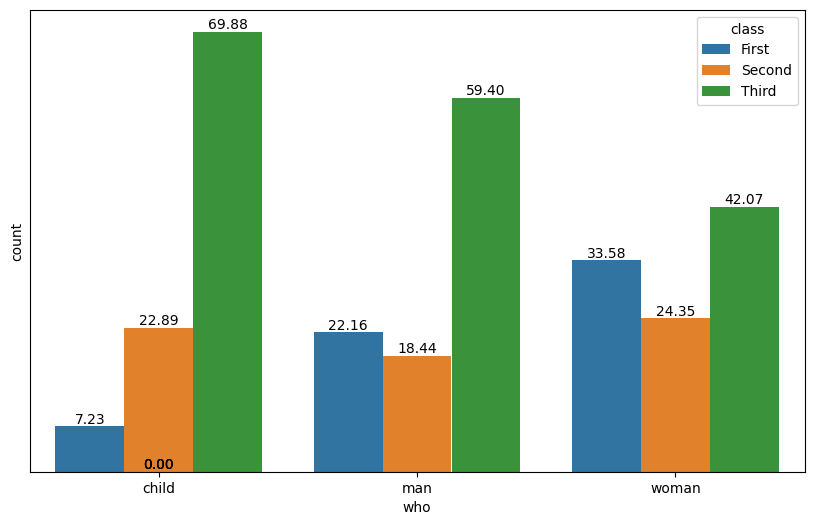

In [20]:
# Para ello utilizaré el diagrama de barras para compararlo de manera bivariante
count_data = df_titanic.groupby(["who", "class"]).size().reset_index(name='count')
total_counts = df_titanic["who"].value_counts()
count_data['count'] = count_data.apply(lambda x: x['count'] / total_counts[x["who"]] * 100, axis=1)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x="who", y='count', hue="class", data=count_data)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.yticks([]);

*La explicación de la supervivencia está en la combinación de factores, las mujeres y niños sobrevivieron más en general pero también el factor clase influyó y había muchos más niños en tercera que mujeres en tercera proprocionalmente*

Ahora realizaré el análisi bivariante entre `class` y `alive`

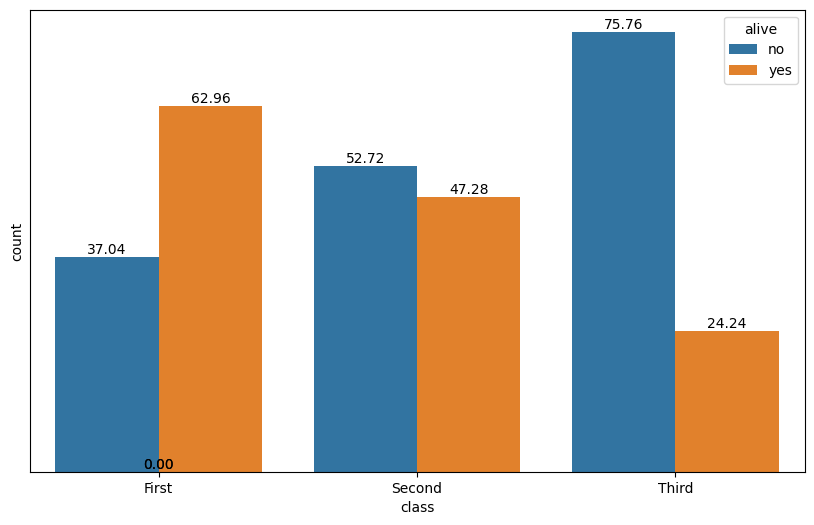

In [21]:
# Para ello utilizaré el diagrama de barras para compararlo de manera bivariante
count_data = df_titanic.groupby(["class", "alive"]).size().reset_index(name='count')
total_counts = df_titanic["class"].value_counts()
count_data['count'] = count_data.apply(lambda x: x['count'] / total_counts[x["class"]] * 100, axis=1)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x="class", y='count', hue="alive", data=count_data)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.yticks([]);

*En términos relativos fue la primera clase la que mayor ratio de supervivencia muestra, aquí además se ve que hay más porcentaje de supervivientes de segunda que de tercera (47% frente a 24%), y que la diferencia en valores absolutos se debe a la diferencia en términos absolutos entre pasajeros que viajaban en segunda y terecera.*

Para comprobar la relevancia estadística de la que parece una realación clara, volvemos al test chi-2

In [22]:
tabla_contingencia = pd.crosstab(df_titanic["alive"],df_titanic["class"])

chi2, p, dof, expected = chi2_contingency(tabla_contingencia)


print("Valor Chi-Cuadrado:", chi2)
print("P-Value:", p)
print("Grados de Libertad:", dof)
print("Tabla de Frecuencias Esperadas:\n", expected)

Valor Chi-Cuadrado: 102.88898875696056
P-Value: 4.549251711298793e-23
Grados de Libertad: 2
Tabla de Frecuencias Esperadas:
 [[133.09090909 113.37373737 302.53535354]
 [ 82.90909091  70.62626263 188.46464646]]


*Como casi erea de esperar, la confianza estadística de la existencia de una relación entre la clase y la supervivencia es muy alta*

> 4. Análisis multivariantes entre `who`, `class` y `alive`

([], [])

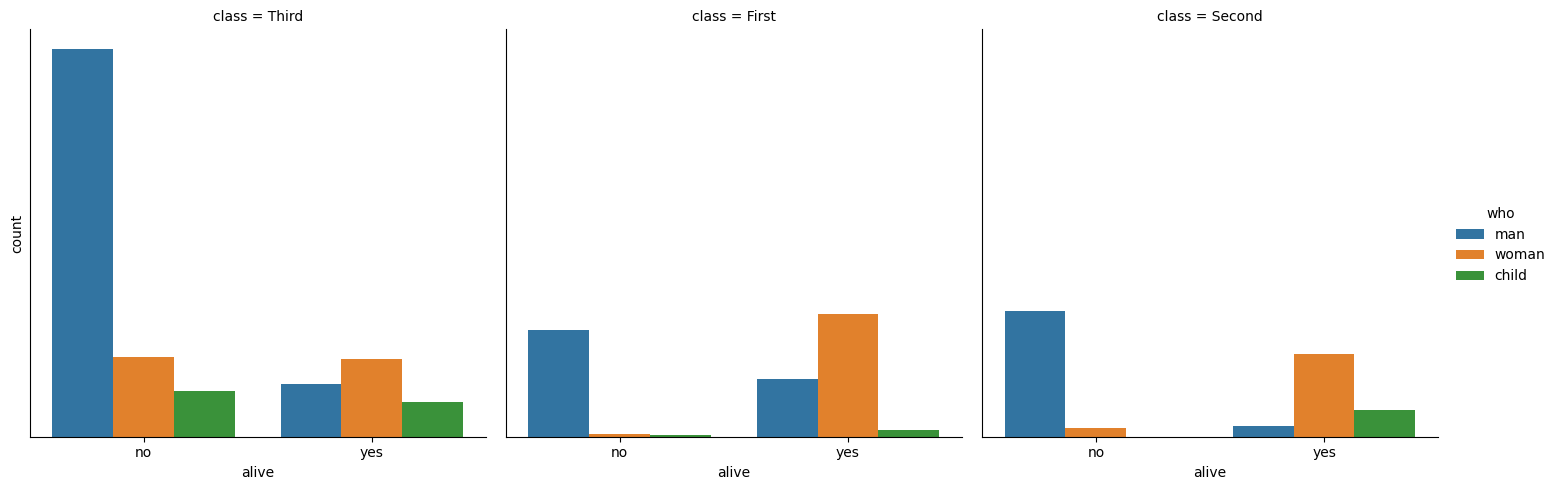

In [23]:
sns.catplot(x= "alive", col = "class", hue = "who", data = df_titanic, kind = "count")
plt.yticks([])

*Se puede observar más claramente la influencia de pertenecer a una case y otra donde los hombres, con mayor tasa de fallecimientos, se concentra su máximo en la tercera clase.*

*Analizando el principio de 'mujeres y niños primero', las mujeres que más sobrevivieron en proporción fueron las pertenecientes a la primera clase y, en cambio, se salvaron más niños de la tercera clase.*

> 4. Análisis bivariante entre `fare`y `alive`

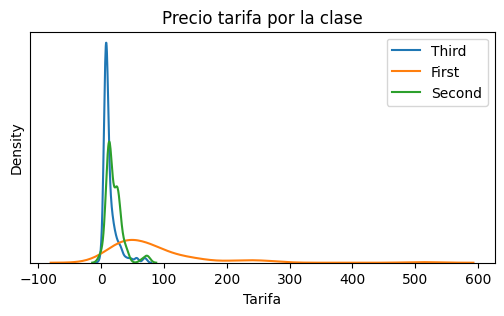

In [32]:
plt.figure(figsize=(6,3))
for valor in df_titanic["class"].unique():  
    sns.kdeplot(df_titanic.loc[df_titanic["class"] == valor, "fare"], label=valor)
plt.legend()
plt.title('Precio tarifa por la clase')
plt.xlabel("Tarifa")
plt.yticks([])
plt.show()

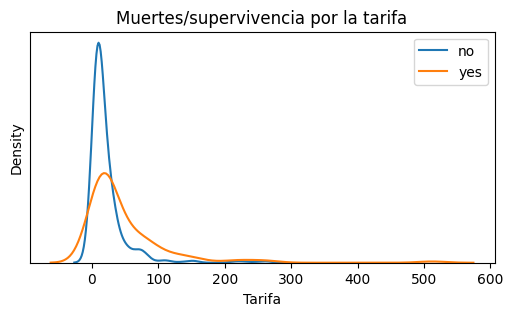

In [34]:
plt.figure(figsize=(6,3))
for valor in df_titanic["alive"].unique():  
    sns.kdeplot(df_titanic.loc[df_titanic["alive"] == valor, "fare"], label=valor)
plt.legend()
plt.title('Muertes/supervivencia por la tarifa')
plt.xlabel("Tarifa")
plt.yticks([])
plt.show()

In [35]:
grupo_a = df_titanic.loc[df_titanic.alive == "yes"]["fare"]
grupo_b = df_titanic.loc[df_titanic.alive == "no"]["fare"]


u_stat, p_valor = mannwhitneyu(grupo_a, grupo_b)

print("Estadístico U:", u_stat)
print("Valor p:", p_valor)

Estadístico U: 129951.5
Valor p: 4.553477179250237e-22


*Con p-value <<<<< 0.05, podemos decir que existe confianza estadística en la relación entre ambas variables*

*Observando las gráficas KDE tanto de `fare` y `alive` como de `fare` y `class`, refleja la clara influencia de pertenecer a primera clase, pagando más tarifa en sus viajes, son sobrevivir, y al contrario: pagar menos tariga pertenenciendo así a la tercera clase y fallecer*